# Sequential NLP - Part 1

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

from keras.datasets import imdb
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

from nltk.stem.porter import PorterStemmer

## Data Extraction, Analysis and Cleaning

In [2]:
data = pd.read_csv('C:\\Users\\Rakesh Gowda S N\\Documents\\Projects\\Project 11 - Sequential NLP\\IMDB Dataset.csv')
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
#Summary of the dataset
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
#sentiment count
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We can observe that both the sentiments are equally distributed and thus we will not face issues related to data imbalance.

Now let us check if there are any missing/null values and also duplicate data if any.

In [5]:
null_values = data.isnull().sum() #identifying missing values

In [6]:
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

There are 0 missing values for review and 0 missing values for sentiment.


In [7]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [8]:
#view duplicate reviews
review = data['review']
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head(10)

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative
2976,"""Witchery"" might just be the most incoherent a...",negative
7949,'Dead Letter Office' is a low-budget film abou...,negative
32260,'Dead Letter Office' is a low-budget film abou...,negative
18022,(Spoilers)<br /><br />Oh sure it's based on Mo...,negative
22449,(Spoilers)<br /><br />Oh sure it's based on Mo...,negative


In [9]:
#drop duplicate reviews
data1 = data.drop_duplicates(inplace = True)

data1 = data.reset_index()
data1 = data1.drop(['index'],axis=1)

In [10]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data1.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


Now let us use stopwords and lemmatization technique

In [11]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()
stemmer = PorterStemmer()

In [12]:
data_copy = data1.copy()

In [13]:
X = data_copy["review"]
y = data_copy["sentiment"]

In [14]:
for i in range(X.shape[0]):
    X[i] = re.sub('[^A-Za-z]', ' ', X[i])       #remove non alphabetic characters, best way to do that is regex method

    X[i] = X[i].split(" ")                      #seperate sentences to words
    X[i] = [w for w in X[i] if w != ""]
    
    X[i] = [stemmer.stem(w) for w in X[i]]      #extract root of the word using stemmer. Gets rid of prefixes and suffixes.
    
    X[i] = [w.lower() for w in X[i]]            #make every word lower case
    X[i] = [w for w in X[i] if w not in stop]

In [15]:
# Create Bag of Words for every review and sort words by frequency

word_dict = {}
for i in range(X.shape[0]):
    for w in X[i]:
        if w not in word_dict:
            word_dict[w] = 0
        word_dict[w] += 1
word_dict = sorted(word_dict.items(), key= lambda x : x[1], reverse=True)

# print most used 20 words

cnt = 0
for k,v in word_dict:
    cnt += 1
    if cnt == 21:
        break
    print(k,v)

br 200428
thi 149838
movi 102504
film 95233
wa 94834
hi 57405
one 55040
like 44836
ha 33156
time 31703
good 29989
make 29832
charact 28129
see 28006
get 27754
watch 27618
veri 27536
even 25153
stori 25121
would 24401


In [16]:
# We will get 10000 most used words and store another dictionary

most_used_words = {}
cnt = 0
index = 0
for word, freq in word_dict:
    most_used_words[word] = index
    index += 1
    cnt += 1
    if cnt == 10000:
        break
list(most_used_words.items())[0:10]

[('br', 0),
 ('thi', 1),
 ('movi', 2),
 ('film', 3),
 ('wa', 4),
 ('hi', 5),
 ('one', 6),
 ('like', 7),
 ('ha', 8),
 ('time', 9)]

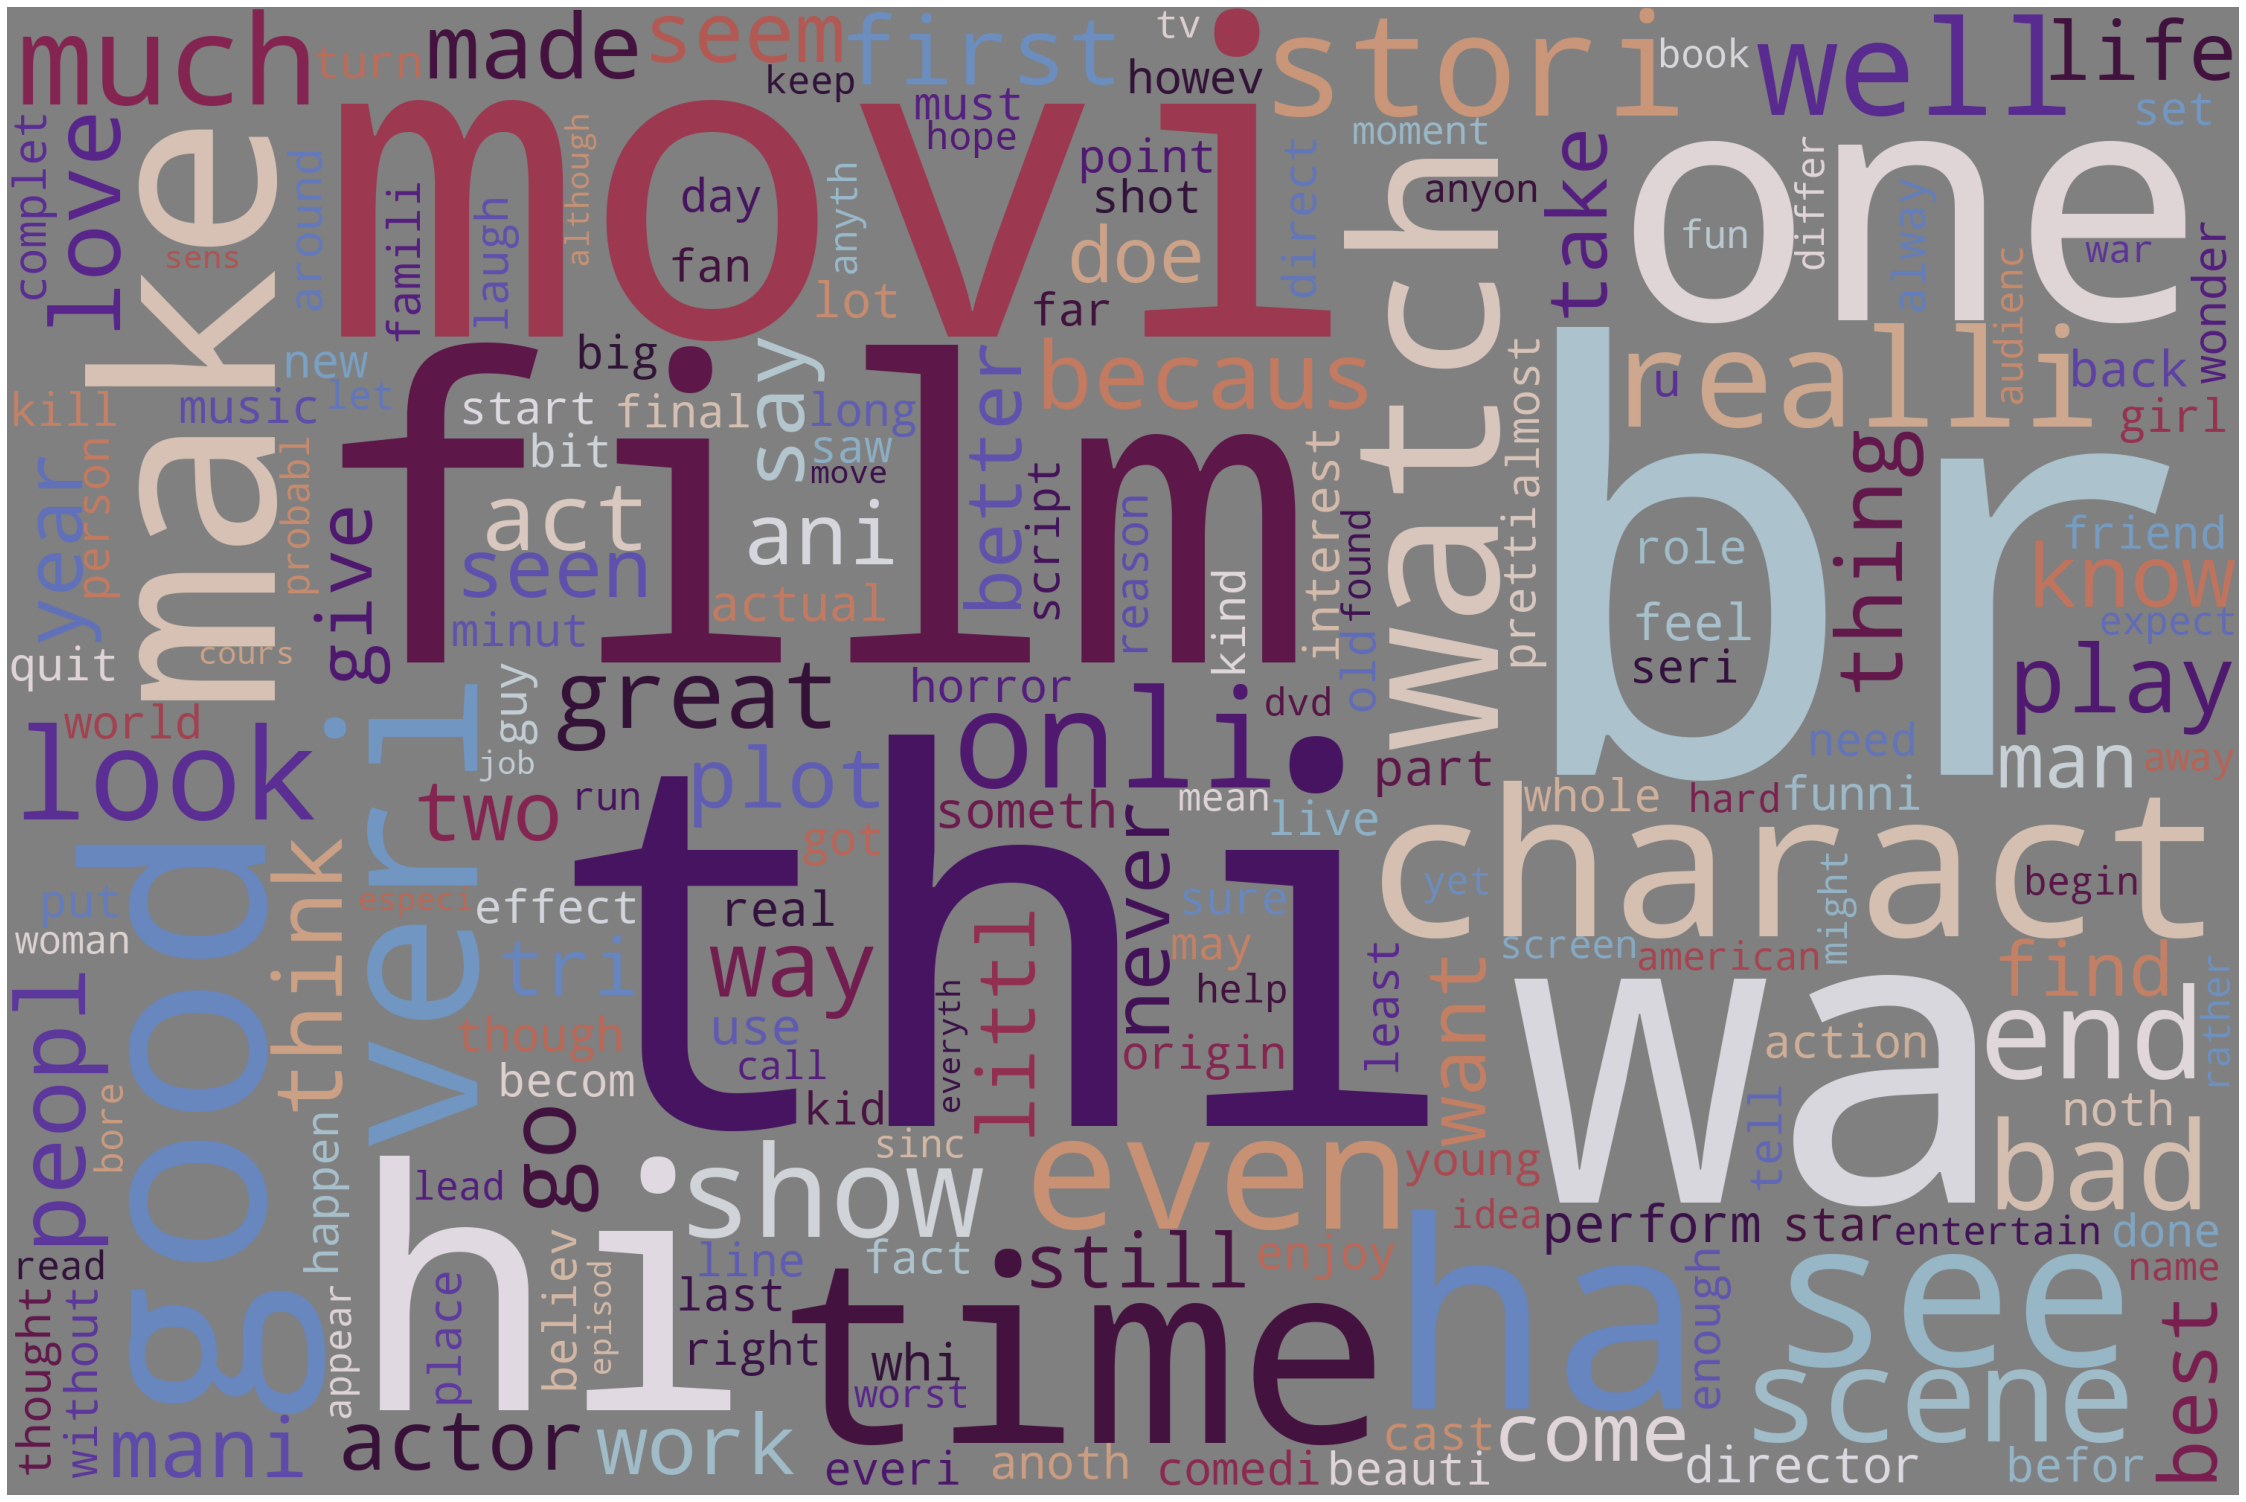

In [17]:
# Print word cloud

text = ""
cnt = 0
for k,v in word_dict:
    cnt += 1
    if cnt == 5000:
        break
    for i in range(v):
        text += k + " "

import matplotlib.pyplot as plt

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
    
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='grey', colormap='twilight', 
                      collocations=False, stopwords = STOPWORDS).generate(text)
plot_cloud(wordcloud)

In [18]:
# Remove words not in most used word dict and we change every word with its index

X_train = []
for i in range(X.shape[0]):
    list_ = []
    for w in X[i]:
        try:
            list_.append(most_used_words[w])
        except:
            pass
    X_train.append(list_)
for i in X_train[0]:
    print(i, end=" ")

6 251 8 365 15 2657 200 1605 122 1 570 117 0 0 35 40 2761 2657 4 1102 23 510 97 122 302 31 1357 1 25 4796 345 8077 1 25 596 1655 1071 614 328 510 3183 246 73 302 0 0 164 2657 6200 317 5309 1813 516 1135 1309 438 3280 1898 767 1871 1773 864 216 235 3620 2502 438 282 51 9962 3362 9002 5537 1055 912 2147 242 2054 5701 417 6598 6285 57 158 176 0 0 19 45 214 808 25 622 113 206 25 1509 680 114 284 1028 2198 189 680 631 680 751 2657 727 118 35 200 62 139 2761 1392 4 1747 45 4 1441 15 374 935 2657 125 7596 235 456 1206 510 510 5023 2900 1699 2586 4296 111 468 14 176 22 987 584 574 4296 104 767 3865 622 313 609 1003 767 355 15 2657 129 145 1816 2651 234 14 447 3373 372 

## Train, tune and test a Sequential Model

In [19]:
# Get average length of lists

leng = 0
for i in range(len(X_train)):
    leng += len(X_train[i])
leng / len(X_train)

125.54541970876528

In [20]:
X_train = np.array(X_train)

Average length of sentences 125, we can use 120. We will constrain size of every sentence to 120. Algorithm will complete smaller sentences to 120 by adding zeros.

In [21]:
X_train = pad_sequences(X_train, 120)

In [22]:
print(X_train.shape)

(49582, 120)


In [23]:
for i in X_train[0]:
    print(i, end=" ")

164 2657 6200 317 5309 1813 516 1135 1309 438 3280 1898 767 1871 1773 864 216 235 3620 2502 438 282 51 9962 3362 9002 5537 1055 912 2147 242 2054 5701 417 6598 6285 57 158 176 0 0 19 45 214 808 25 622 113 206 25 1509 680 114 284 1028 2198 189 680 631 680 751 2657 727 118 35 200 62 139 2761 1392 4 1747 45 4 1441 15 374 935 2657 125 7596 235 456 1206 510 510 5023 2900 1699 2586 4296 111 468 14 176 22 987 584 574 4296 104 767 3865 622 313 609 1003 767 355 15 2657 129 145 1816 2651 234 14 447 3373 372 

We will build both LSTM and GRU models. The Gated Recurrent Unit (GRU) is a type of Recurrent Neural Network (RNN) that, in certain cases, has advantages over long short term memory (LSTM). GRU uses less memory and is faster than LSTM, however, LSTM is more accurate when using datasets with longer sequences.

In [24]:
y[0:5]

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [25]:
#converting target variable to numeric labels
y = [1 if i=="positive" else 0 for i in y]
y[0:5]

[1, 1, 1, 0, 1]

In [26]:
#splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, np.array(y), test_size = 0.3)

### LSTM

In [27]:
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(10000, 32, input_length=120))
lstm_model.add(keras.layers.LSTM(100, return_sequences = True))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.LSTM(100, return_sequences = False))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.Dense(1, activation="sigmoid"))
lstm_model.compile(optimizer="rmsprop", loss=keras.losses.binary_crossentropy, metrics="accuracy")

In [28]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [29]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)
mcp_save = keras.callbacks.ModelCheckpoint('chkpnt_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)

In [30]:
history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data = (X_test, y_test),
                   callbacks = [learning_rate_reduction, early_stopping, mcp_save])

Epoch 1/5
1085/1085 [==============================] - 112s 100ms/step - loss: 0.4568 - accuracy: 0.7794 - val_loss: 0.2955 - val_accuracy: 0.8787

Epoch 00001: val_loss improved from inf to 0.29548, saving model to chkpnt_model.hdf5
Epoch 2/5
1085/1085 [==============================] - 109s 100ms/step - loss: 0.2706 - accuracy: 0.8925 - val_loss: 0.3089 - val_accuracy: 0.8719

Epoch 00002: val_loss did not improve from 0.29548
Epoch 3/5
1085/1085 [==============================] - 108s 99ms/step - loss: 0.2490 - accuracy: 0.9037 - val_loss: 0.2886 - val_accuracy: 0.8811

Epoch 00003: val_loss improved from 0.29548 to 0.28862, saving model to chkpnt_model.hdf5
Epoch 4/5
1085/1085 [==============================] - 108s 99ms/step - loss: 0.2227 - accuracy: 0.9141 - val_loss: 0.2954 - val_accuracy: 0.8777

Epoch 00004: val_loss did not improve from 0.28862
Epoch 5/5
1085/1085 [==============================] - 107s 99ms/step - loss: 0.2037 - accuracy: 0.9217 - val_loss: 0.2774 - val_acc

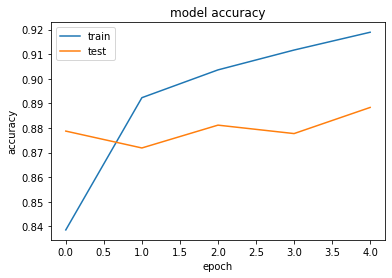

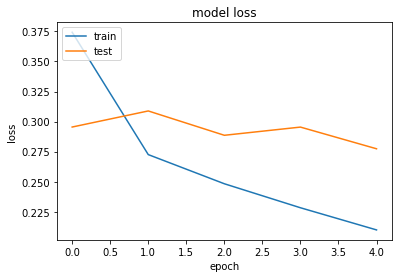

In [31]:
plot_history(history)

In [32]:
lstm_model.load_weights('chkpnt_model.hdf5')

### GRU

In [33]:
gru_model = keras.Sequential()
gru_model.add(keras.layers.Embedding(10000, 32, input_length=120))
gru_model.add(keras.layers.GRU(100, return_sequences = True, activation = "tanh"))
gru_model.add(keras.layers.Dropout(0.5))
gru_model.add(keras.layers.GRU(100, return_sequences = False, activation = "tanh"))
gru_model.add(keras.layers.Dropout(0.5))
gru_model.add(keras.layers.Dense(1, activation="sigmoid"))
gru_model.compile(optimizer="rmsprop", loss=keras.losses.binary_crossentropy, metrics="accuracy")

In [34]:
history = gru_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data = (X_test, y_test),
                   callbacks = [learning_rate_reduction, early_stopping, mcp_save])

Epoch 1/5
1085/1085 [==============================] - 112s 100ms/step - loss: 0.4873 - accuracy: 0.7502 - val_loss: 0.3054 - val_accuracy: 0.8703

Epoch 00001: val_loss did not improve from 0.27740
Epoch 2/5
1085/1085 [==============================] - 102s 94ms/step - loss: 0.2645 - accuracy: 0.8934 - val_loss: 0.2753 - val_accuracy: 0.8848

Epoch 00002: val_loss improved from 0.27740 to 0.27534, saving model to chkpnt_model.hdf5
Epoch 3/5
1085/1085 [==============================] - 102s 94ms/step - loss: 0.2233 - accuracy: 0.9132 - val_loss: 0.2824 - val_accuracy: 0.8885

Epoch 00003: val_loss did not improve from 0.27534
Epoch 4/5
1085/1085 [==============================] - 102s 94ms/step - loss: 0.1974 - accuracy: 0.9259 - val_loss: 0.2644 - val_accuracy: 0.8891

Epoch 00004: val_loss improved from 0.27534 to 0.26445, saving model to chkpnt_model.hdf5
Epoch 5/5
1085/1085 [==============================] - 102s 94ms/step - loss: 0.1697 - accuracy: 0.9373 - val_loss: 0.3264 - val_

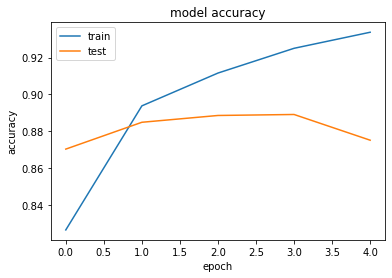

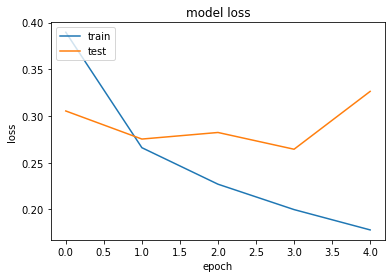

In [35]:
plot_history(history)

In [36]:
gru_model.save_weights('chkpnt_model.hdf5')

## Using the designed model to print the prediction

In [37]:
def predict(review):
    
    # remove non alphabetic characters
    review = re.sub('[^A-Za-z]', ' ', review) 
    
    # Stemmer
    review = review.split(" ")
    review = [w for w in review if w != ""]
    review = [stemmer.stem(w) for w in review]
    
    # remove stopwords
    review = [w for w in review if w not in stop]
    
    # get bag of words
    list_ = []
    for w in review:
        try:
            list_.append(most_used_words[w])
        except:
            pass
    test = [list_]
    test = np.array(test)
    test = pad_sequences(test, 120)
#     pred = lstm_model.predict(test)[0][0]
    pred = gru_model.predict(test)[0][0]
    print("Positive : ", pred)
    print("Negative : ", 1-pred)

Let us check the reviews from the movie 'Interstellar'

In [38]:
positive_08star = "Not everyone in Interstellar recognizes the potential of advanced technology. Most dismiss it as a waste \
                   of time and resources, and not just old curmudgeons feel this way. Thoughtful, intelligent young         \
                   characters share this sentiment. This belief gained steam following a world-wide blight that wiped out   \
                   the vast majority of life on earth—crops and humans."

In [39]:
predict(positive_08star)

Positive :  0.8455322
Negative :  0.15446782112121582


In [40]:
positive_10star = "Beautifully filmed, technically magnificent, great acting, rock solid original story, scientifically     \
                   accurate, and most importantly, it doesn't have a weird floating baby as an ending. Interstellar in near \
                   about perfection. Everything that Kubrick, very pretentiously wanted to achieve, Nolan made it look      \
                   effortless. On addition, McConaughey's and Chastain's performances are simply breathtaking."

In [41]:
predict(positive_10star)

Positive :  0.9848669
Negative :  0.015133082866668701


In [42]:
negative_1star = "WAY overpraised and terrible sci-fi movie. When I heard the plot from this I expected the worst.Also the \
                  gaps in logic and plot holes here are very annoying. I lost track of how many times I rolled my eyes at  \
              t   he dubious 'logic' served up here."

In [43]:
predict(negative_1star)

Positive :  0.021150887
Negative :  0.9788491129875183


In [44]:
negative_3star = "The film is spectacular and starts off really nice and promises to be very interesting. But once the         \
                  spaceship leaves the ground, the movie deteriorates rapidly, and as it progresses it becomes so unbelievable \
                  and ludicrous, that I left the theater quite annoyed and very disappointed. I didn't like most of the        \
                  characters. They are clichés, and none made me sympathetic to their cause or character. The robot is also    \
                  extremely familiar and it's design is ludicrous, trying to be both advanced and ancient at the same time.    \
                  I really likes other films by the Nolan brothers, but it seems they don't give their scripts as much         \
                  attention as they used to. A disappointment."

In [45]:
predict(negative_3star)

Positive :  0.0069669783
Negative :  0.9930330216884613
